Официальное название:

## Компартментные модели динамики эпидемий

*Автор: Ян Пиле, Mail.ru group, НИУ ВШЭ*

Неофициальное название:

# Как с помощью элементарной логики и небольшого количества математики попытаться спрогнозировать динамику эпидемии инфекционного заболевания.


## или

# Wie man mit dem Hammer Epidemien prognosiert[(c)](https://ru.wikipedia.org/wiki/Сумерки_идолов)

<br><img src='https://stroybrusok.ru/image/cache/catalog/catalog/molotok_gvozdodyor-800x800.png' width = "400"> 


## или 

# SIR, yes SIR.
<br>
<br><img src='https://www.meme-arsenal.com/memes/9dbf06998cc661a5ad97abac4800d49d.jpg'  width = "800"> 


## Переводы шуток: SIR == Susceptible, Infected, Recovered

Думаю, события последнего года всех убедили в том, что моделирование эпидемий – необходимость. Проблема в том, что для многих сфера эпидемиологии не является очень близкой и порой просто непонятно, как к ней подступиться.

Сегодня мы попробуем организовать введение в тему моделирования инфекционных заболеваний. Мы последовательно проработаем модель SIR, выведем ее уравнения и сделаем имплементацию на языке Python. Далее попробуем дополнить нашу модель и подогнать ее под данные о всем нам (В 2020 году) известном вирусе SARS-CoV-2.

<img src="http://upload.wikimedia.org/wikipedia/commons/thumb/a/a2/GeorgeEPBox.jpg/200px-GeorgeEPBox.jpg"> Известный статистик Джордж Бокс сказал:

*Все модели неверны, но некоторые полезны.*

Мы собираемся моделировать инфекционные заболевания. Подразумевается, что такие заболевания могут распространятся от одного человека к другому. Попытаемся понять, насколько быстро они распространяются, какую часть популяции заражают, какая доля умирает и т.д. Один из самых простых способов их моделирования (и то, на чем мы здесь сосредоточены) - это использование компартментной модели. 

Компартментная модель разделяет популяцию на несколько частей, например:

$S – (Susceptible)$ – Восприимчивые (все еще могут быть инфицированы, но на данный момент здоровы)

$I – (Infected)$ – Зараженные

$R – (Recovered)$ – Вылечившиеся (уже были заражены, снова заразиться не могут)

Представим, что у нас есть население размера N = 1000 (1000 человек), и мы знаем, что 400 человек из них инфицированы в момент времени t (например, t = 7 дней после вспышки болезни). Это обозначается $S(7) = 400$. Модель $SIR$ позволяет нам, только путем ввода некоторых начальных параметров, получить все значения $S(t)$, $I(t)$, $R(t)$ для всех дней $t$. 

Приведем пример:
У нас есть новое заболевание, болезнь X. Для этого заболевания вероятность инфицированного человека заразить здорового составляет 20%. Среднее количество людей, с которыми человек контактирует в день, составляет 5. Таким образом, за день инфицированный встречается с 5 людьми и заражает каждого с вероятностью 20%. Таким образом, мы ожидаем, что этот человек заразит 1 человека (20% ⋅ 5 = 1) в день. Это $\beta$ («бета»), ожидаемое количество людей, инфицированных инфицированным в день.

Теперь видно, что количество дней, в течение которых инфицированный человек может распространять болезнь, крайне важно. Назовем это число $D$. Если $D = 7$, инфицированный человек ходит целую неделю, распространяя болезнь, и заражает 1 человека в день (поскольку $\beta = 1$). Таким образом, мы ожидаем, что инфицированный человек заразит 1-7 человек (1 раз в день по 7 дней) = 7 других людей. Это базовое репродуктивное число $\rho$, общее количество людей, зараженных одним инфицированным. Мы просто использовали интуитивную формулу: $\rho_0 = \beta D$.
На самом деле, нам больше ничего не нужно, только одно маленькое обозначение: $\gamma = \frac1{D}$, поэтому, если вы думаете о D как о количестве дней, в течение которых инфицированный человек болеет, вы можете думать о γ как скорость выздоровления или доля инфицированных, выздоравливающих за день. Например, если в настоящее время инфицировано 30 человек и D = 3 (значит, они инфицированы в течение трех дней), то в день 1/3 (то есть 10) из них выздоравливают, поэтому $\gamma = \frac1{3}$. Поскольку $\gamma = \frac1{D}$, подставляя в $\rho_0 = \beta D$, имеем  $\rho_0= \frac\beta{\gamma}$ .

## SIR модель

Модель, про которую мы будем говорить, выглядит так:
<br><img src='https://www.researchgate.net/profile/Simon_Dodds2/publication/342709327/figure/fig1/AS:910267508609025@1594036094222/The-set-of-three-differential-equations-that-describe-the-SIR-model-Wikipedia.ppm'  width = "200"> 

Если быть совсем буквоедом, то рассматриваемое у нас время дискретно и поэтому по факту система выглядит так:
<br><img src='https://i.stack.imgur.com/XHFdg.jpg'  width = "350"> 

In [116]:
from scipy.integrate import odeint
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
import lmfit
from lmfit.lineshapes import gaussian, lorentzian
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [117]:
def deriv(y, t, N, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

In [81]:
N = 1000
beta = 1.0  # Инфицированный заражает по одному человеку в день
D = 4.0 # Заболевание длится 4 дня
gamma = 1.0 / D

S0, I0, R0 = 999, 1, 0  # Начальные условия: Один зараженный, оставшиеся – восприимчивые

In [118]:
t = np.linspace(0, 49, 50) # Сетка по времени (в днях)
y0 = S0, I0, R0 # Вектор начальных условий

# Интегрируем уравнения SIR по временной сетке t.
ret = odeint(deriv, y0, t, args=(N, beta, gamma))
S, I, R = ret.T

In [119]:
def sirplot(t, S, I, R):
    f, ax = plt.subplots(1,1,figsize=(10,4))
    ax.plot(t, S, c = 'b', alpha=0.7, linewidth=2, label='Susceptible')
    ax.plot(t, I, c = 'red', alpha=0.7, linewidth=2, label='Infected')
    ax.plot(t, R, c = 'green', alpha=0.7, linewidth=2, label='Recovered')

    ax.set_xlabel('Время (дни)')

    ax.yaxis.set_tick_params(length=0)
    ax.xaxis.set_tick_params(length=0)
    ax.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)
    plt.show();

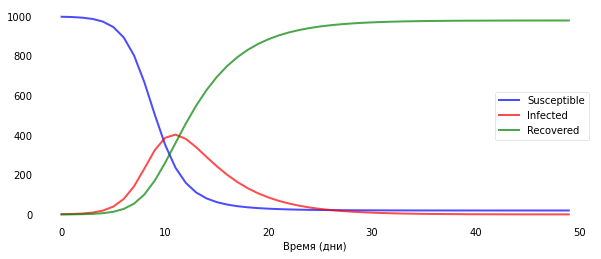

In [120]:
sirplot(t, S, I, R)

In [123]:
R

array([0.00000000e+00, 3.72033735e-01, 1.15746227e+00, 2.80997494e+00,
       6.26204685e+00, 1.33682013e+01, 2.75741480e+01, 5.44527307e+01,
       1.00783625e+02, 1.70596945e+02, 2.60453148e+02, 3.60197173e+02,
       4.58933005e+02, 5.49367203e+02, 6.28216857e+02, 6.94885922e+02,
       7.50172521e+02, 7.95446657e+02, 8.32211260e+02, 8.61893724e+02,
       8.85760831e+02, 9.04895590e+02, 9.20203236e+02, 9.32429517e+02,
       9.42182828e+02, 9.49956151e+02, 9.56147018e+02, 9.61074855e+02,
       9.64995651e+02, 9.68114156e+02, 9.70593885e+02, 9.72565272e+02,
       9.74132272e+02, 9.75377675e+02, 9.76367382e+02, 9.77153827e+02,
       9.77778715e+02, 9.78275210e+02, 9.78669676e+02, 9.78983070e+02,
       9.79232048e+02, 9.79429846e+02, 9.79586983e+02, 9.79711815e+02,
       9.79810982e+02, 9.79889762e+02, 9.79952344e+02, 9.80002059e+02,
       9.80041552e+02, 9.80072925e+02])

По сути, получается, что наши люди прошли через следующую цепочку:

<img src="https://media.springernature.com/lw685/springer-static/image/art%3A10.1038%2Fsrep46076/MediaObjects/41598_2017_Article_BFsrep46076_Fig1_HTML.jpg"> 

Группы *S*, *I* и *R* называют **компартментами**, а модели, использующие подобное разбиение на группы, соответственно, **компартментными**.

## Коротко о том, как можно "Подгонять" функции

Возьмем функцию Гаусса (как нормальное распределение, только не обязательно нормированная) и добавим к ней случайный шум со средним 0 и амплитудой до 0.1. 

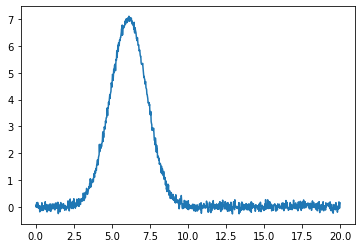

In [124]:
np.random.seed(42)
x = np.linspace(0, 20.0, 1001)

data = (gaussian(x, 21, 6.1, 1.2) + np.random.normal(scale=0.1, size=x.size))  # normal distr. with some noise
plt.plot(x, data);

In [126]:
def f(x, a, b, c):
    return gaussian(x, a, b, c)

Библиотека lmfit с помощью указанного метода оптимизации попытается подобрать вам такие значения параметров, чтобы точность была максимальной. Например ниже использован метод наименьших квадратов.

In [127]:
mod = lmfit.Model(f)
# Устанавливаем начальные значения параметров (с которых стартует оптимизация)
mod.set_param_hint("a", value=10.0, vary=True)
mod.set_param_hint("b", value=10.0, vary=True)
mod.set_param_hint("c", value=10.0, vary=True)

params = mod.make_params()

In [128]:
result = mod.fit(data, params, method="leastsq", x=x)  # fitting

На выходе получаем такую функцию. Как видите, параметры мы почти угадали. Но надо понимать, что тут целевую функцию мы знали заранее.

{'a': 21.03260705312548, 'b': 6.100343154231026, 'c': 1.2009255088579456}

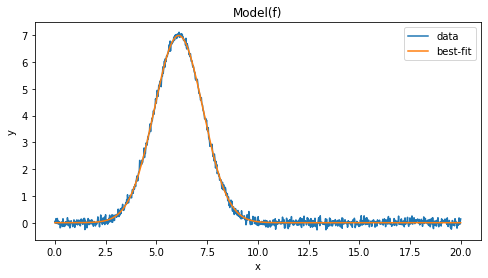

In [129]:
plt.figure(figsize=(8,4))
result.plot_fit(datafmt="-");
result.best_values

In [67]:
result

## Усложним нашу модель SIR:

## SIR -> SEICRD

Заметим, что переходы между компартментами описываются довольно простой формулой:

<img src="rate_prob_pop.png"> 

Мы добавили три компартмента:

    * Exposed - носители вируса на периоде инкубации
    * Critical – Люди, помещенные в больничные палаты
    * Dead – не требует объяснения


<img src="SEIRCD.png"> 

Итоговые уравнения тогда будут иметь вид:

<img src="equations final.png"> 

In [130]:
# Считываем данные
beds = pd.read_csv("https://raw.githubusercontent.com/hf2000510/infectious_disease_modelling/master/data/beds.csv", header=0)
agegroups = pd.read_csv("https://raw.githubusercontent.com/hf2000510/infectious_disease_modelling/master/data/agegroups.csv")
probabilities = pd.read_csv("https://raw.githubusercontent.com/hf2000510/infectious_disease_modelling/master/data/probabilities.csv")
covid_data = pd.read_csv("https://tinyurl.com/t59cgxn", parse_dates=["Date"], skiprows=[1])
covid_data["Location"] = covid_data["Country/Region"]

# Словари, чтоб доставать данные побыстрее

# 1. Кол-во больничных коек на 100000 человек
beds_lookup = dict(zip(beds["Country"], beds["ICU_Beds"]))

# 2. возрастные группы
agegroup_lookup = dict(zip(agegroups['Location'], agegroups[['0_9', '10_19', '20_29', '30_39', '40_49', '50_59', '60_69', '70_79', '80_89', '90_100']].values))

# вероятности
# prob_I_to_C_1 = list(probabilities.prob_I_to_ICU_1.values)
# prob_I_to_C_2 = list(probabilities.prob_I_to_ICU_2.values)
# prob_C_to_Death_1 = list(probabilities.prob_ICU_to_Death_1.values)
# prob_C_to_Death_2 = list(probabilities.prob_ICU_to_Death_2.values)

In [115]:
probabilities

,Age,prob_I_to_ICU_1,prob_ICU_to_Death_1,prob_I_to_ICU_2,prob_ICU_to_Death_2
0,0_9,0.001,0.00,0.00100,0.000
1,10_19,0.003,0.00,0.00300,0.000
2,20_29,0.009,0.05,0.00600,0.000
3,30_39,0.025,0.06,0.00900,0.000
4,40_49,0.030,0.10,0.02500,0.120
5,50_59,0.050,0.26,0.03560,0.365
6,60_69,0.070,0.57,0.05926,0.675
7,70_79,0.100,0.86,0.10100,0.850
8,80_89,0.140,0.95,0.14100,0.950
9,90_100,0.160,0.98,0.16000,0.990


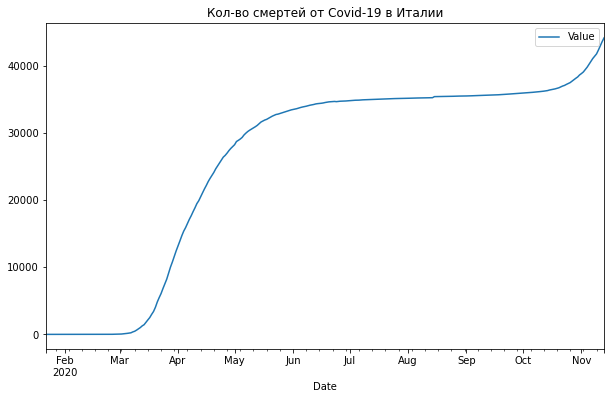

In [131]:
covid_data[covid_data['Location']=='Italy'].groupby("Date").sum()[["Value"]].plot(figsize=(10, 6), 
                                                 title="Кол-во смертей от Covid-19 в Италии");

In [140]:
plt.gcf().subplots_adjust(bottom=0.15)

def plotter(t, S, E, I, C, R, D, R_0, B, S_1=None, S_2=None, x_ticks=None):
    if S_1 is not None and S_2 is not None:
        print(f"Доля попадающих в больницы: {S_1*100}; Доля умирающих в больницах: {S_2 * 100}")


    f, ax = plt.subplots(1,1,figsize=(20,4))
    if x_ticks is None:
        ax.plot(t, S, 'b', alpha=0.7, linewidth=2, label='Susceptible')
        ax.plot(t, E, 'y', alpha=0.7, linewidth=2, label='Exposed')
        ax.plot(t, I, 'r', alpha=0.7, linewidth=2, label='Infected')
        ax.plot(t, C, 'r--', alpha=0.7, linewidth=2, label='Critical')
        ax.plot(t, R, 'g', alpha=0.7, linewidth=2, label='Recovered')
        ax.plot(t, D, 'k', alpha=0.7, linewidth=2, label='Dead')
    else:
        ax.plot(x_ticks, S, 'b', alpha=0.7, linewidth=2, label='Susceptible')
        ax.plot(x_ticks, E, 'y', alpha=0.7, linewidth=2, label='Exposed')
        ax.plot(x_ticks, I, 'r', alpha=0.7, linewidth=2, label='Infected')
        ax.plot(x_ticks, C, 'r--', alpha=0.7, linewidth=2, label='Critical')
        ax.plot(x_ticks, R, 'g', alpha=0.7, linewidth=2, label='Recovered')
        ax.plot(x_ticks, D, 'k', alpha=0.7, linewidth=2, label='Dead')

        ax.xaxis.set_major_locator(mdates.YearLocator())
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        ax.xaxis.set_minor_locator(mdates.MonthLocator())
        f.autofmt_xdate()


    ax.title.set_text('Расширенная модель SEIR')

    ax.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)

    plt.show();
    
    f = plt.figure(figsize=(20,4))
    
    # sp1
    ax1 = f.add_subplot(131)
    if x_ticks is None:
        ax1.plot(t, R_0, 'b--', alpha=0.7, linewidth=2, label='R_0')
    else:
        ax1.plot(x_ticks, R_0, 'b--', alpha=0.7, linewidth=2, label='R_0')
        ax1.xaxis.set_major_locator(mdates.YearLocator())
        ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        ax1.xaxis.set_minor_locator(mdates.MonthLocator())
        f.autofmt_xdate()

 
    ax1.title.set_text('R_0 от времени')
    ax1.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax1.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)
    
    # sp2
    ax2 = f.add_subplot(132)
    total_CFR = [0] + [100 * D[i] / sum(sigma*E[:i]) if sum(sigma*E[:i])>0 else 0 for i in range(1, len(t))]
    daily_CFR = [0] + [100 * ((D[i]-D[i-1]) / ((R[i]-R[i-1]) + (D[i]-D[i-1]))) if max((R[i]-R[i-1]), (D[i]-D[i-1]))>10 else 0 for i in range(1, len(t))]
    if x_ticks is None:
        ax2.plot(t, total_CFR, 'r--', alpha=0.7, linewidth=2, label='total')
        ax2.plot(t, daily_CFR, 'b--', alpha=0.7, linewidth=2, label='daily')
    else:
        ax2.plot(x_ticks, total_CFR, 'r--', alpha=0.7, linewidth=2, label='total')
        ax2.plot(x_ticks, daily_CFR, 'b--', alpha=0.7, linewidth=2, label='daily')
        ax2.xaxis.set_major_locator(mdates.YearLocator())
        ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        ax2.xaxis.set_minor_locator(mdates.MonthLocator())
        f.autofmt_xdate()

    ax2.title.set_text('Смертность (%)')
    ax2.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax2.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)

    # sp3
    ax3 = f.add_subplot(133)
    newDs = [0] + [D[i]-D[i-1] for i in range(1, len(t))]
    if x_ticks is None:
        ax3.plot(t, newDs, 'r--', alpha=0.7, linewidth=2, label='Общее кол-во')
        ax3.plot(t, [max(0, C[i]-B(i)) for i in range(len(t))], 'b--', alpha=0.7, linewidth=2, label="Переполнение больниц")
    else:
        ax3.plot(x_ticks, newDs, 'r--', alpha=0.7, linewidth=2, label='Общее кол-во')
        ax3.plot(x_ticks, [max(0, C[i]-B(i)) for i in range(len(t))], 'b--', alpha=0.7, linewidth=2, label="Переполнение больниц")
        ax3.xaxis.set_major_locator(mdates.YearLocator())
        ax3.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        ax3.xaxis.set_minor_locator(mdates.MonthLocator())
        f.autofmt_xdate()

    ax3.title.set_text('Кол-во смертей в день')
    ax3.yaxis.set_tick_params(length=0)
    ax3.xaxis.set_tick_params(length=0)
    ax3.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax3.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)

    plt.show();


<Figure size 432x288 with 0 Axes>

In [141]:
def deriv(y, t, beta, gamma, sigma, N, p_I_to_C, p_C_to_D, Beds):
    S, E, I, C, R, D = y

    dSdt = -beta(t) * I * S / N
    dEdt = beta(t) * I * S / N - sigma * E
    dIdt = sigma * E - 1/12.0 * p_I_to_C * I - gamma * (1 - p_I_to_C) * I
    dCdt = 1/12.0 * p_I_to_C * I - 1/7.5 * p_C_to_D * min(Beds(t), C) - max(0, C-Beds(t)) - (1 - p_C_to_D) * 1/6.5 * min(Beds(t), C)
    dRdt = gamma * (1 - p_I_to_C) * I + (1 - p_C_to_D) * 1/6.5 * min(Beds(t), C)
    dDdt = 1/7.5 * p_C_to_D * min(Beds(t), C) + max(0, C-Beds(t))
    return dSdt, dEdt, dIdt, dCdt, dRdt, dDdt

In [142]:
gamma = 1.0/9.0
sigma = 1.0/3.0

def logistic_R_0(t, R_0_start, k, x0, R_0_end):
    return (R_0_start-R_0_end) / (1 + np.exp(-k*(-t+x0))) + R_0_end

def Model(days, agegroups, beds_per_100k, R_0_start, k, x0, R_0_end, prob_I_to_C, prob_C_to_D, s):

    def beta(t):
        return logistic_R_0(t, R_0_start, k, x0, R_0_end) * gamma

    N = sum(agegroups)
    
    def Beds(t):
        beds_0 = beds_per_100k / 100_000 * N
        return beds_0 + s*beds_0*t  # 0.003

    y0 = N-1.0, 1.0, 0.0, 0.0, 0.0, 0.0
    t = np.linspace(0, days-1, days)
    ret = odeint(deriv, y0, t, args=(beta, gamma, sigma, N, prob_I_to_C, prob_C_to_D, Beds))
    S, E, I, C, R, D = ret.T
    R_0_over_time = [beta(i)/gamma for i in range(len(t))]

    return t, S, E, I, C, R, D, R_0_over_time, Beds, prob_I_to_C, prob_C_to_D

Доля попадающих в больницы: 5.0; Доля умирающих в больницах: 60.0


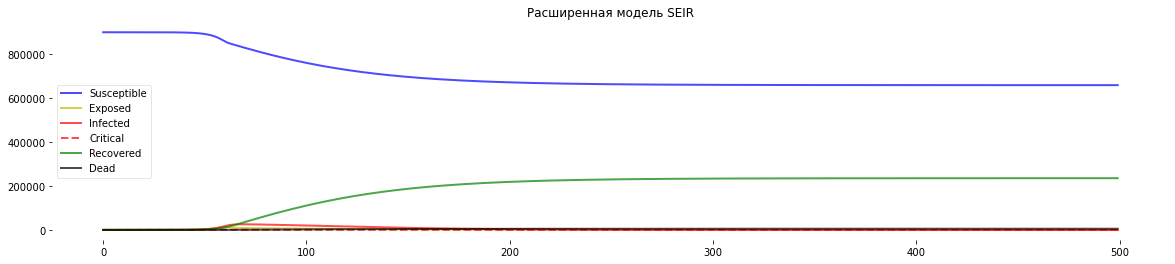

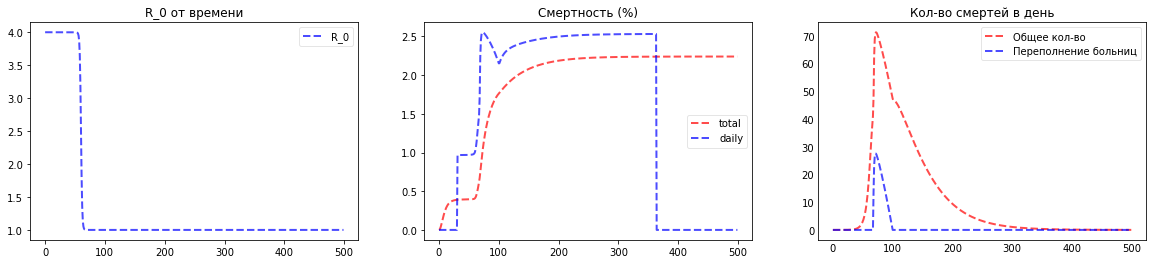

In [143]:
plotter(*Model(days=500, agegroups=[100000, 100000, 100000, 100000, 100000, 100000, 100000, 100000, 100000], 
               beds_per_100k=50, R_0_start=4.0, k=1.0, x0=60, R_0_end=1.0, 
               prob_I_to_C=0.05, prob_C_to_D=0.6, s=0.003))

In [144]:
# parameters
data = covid_data[covid_data["Location"] == "Italy"]["Value"].values[::-1]
agegroups = agegroup_lookup["Italy"]
beds_per_100k = beds_lookup["Italy"]
outbreak_shift = 30
params_init_min_max = {"R_0_start": (3.0, 2.0, 5.0), "k": (2.5, 0.01, 5.0), 
                       "x0": (90, 0, 120), "R_0_end": (0.9, 0.3, 3.5),
                       "prob_I_to_C": (0.05, 0.01, 0.1), "prob_C_to_D": (0.5, 0.05, 0.8),
                       "s": (0.003, 0.001, 0.01)}  # form: {parameter: (Начальное предположение, min, max)}

In [145]:
days = outbreak_shift + len(data)
if outbreak_shift >= 0:
    y_data = np.concatenate((np.zeros(outbreak_shift), data))
else:
    y_data = y_data[-outbreak_shift:]

x_data = np.linspace(0, days - 1, days, dtype=int)  # x_data – список [0, 1, ..., max_days]

def fitter(x, R_0_start, k, x0, R_0_end, prob_I_to_C, prob_C_to_D, s):
    ret = Model(days, agegroups, beds_per_100k, R_0_start, k, x0, R_0_end, prob_I_to_C, prob_C_to_D, s)
    return ret[6][x]

In [146]:
def fitter(x, R_0_start, k, x0, R_0_end, prob_I_to_C, prob_C_to_D, s):
    ret = Model(days, agegroups, beds_per_100k, R_0_start, k, x0, R_0_end, prob_I_to_C, prob_C_to_D, s)
    return ret[6][x]

In [147]:
mod = lmfit.Model(fitter)

for kwarg, (init, mini, maxi) in params_init_min_max.items():
    mod.set_param_hint(str(kwarg), value=init, min=mini, max=maxi, vary=True)

params = mod.make_params()
fit_method = "leastsq"

In [148]:
params

name,value,initial value,min,max,vary
R_0_start,3.00000000,None,2.00000000,5.00000000,True
k,2.50000000,None,0.01000000,5.00000000,True
x0,90.0000000,None,0.00000000,120.000000,True
R_0_end,0.90000000,None,0.30000000,3.50000000,True
prob_I_to_C,0.05000000,None,0.01000000,0.10000000,True
prob_C_to_D,0.50000000,None,0.05000000,0.80000000,True
s,0.00300000,None,1.0000e-03,0.01000000,True


In [149]:
result = mod.fit(y_data, params, method="least_squares", x=x_data)

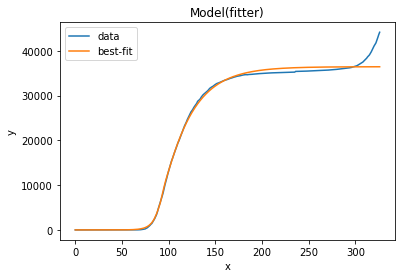

In [150]:
result.plot_fit(datafmt="-");

In [109]:
result.best_values


{'R_0_start': 2.4806391020752607,
 'k': 1.3271553823365672,
 'x0': 83.26897353413997,
 'R_0_end': 0.8028864252977291,
 'prob_I_to_C': 0.04893482633951362,
 'prob_C_to_D': 0.42215668435248477,
 's': 0.0067191586828231524}

In [111]:
probabilities

,Age,prob_I_to_ICU_1,prob_ICU_to_Death_1,prob_I_to_ICU_2,prob_ICU_to_Death_2
0,0_9,0.001,0.00,0.00100,0.000
1,10_19,0.003,0.00,0.00300,0.000
2,20_29,0.009,0.05,0.00600,0.000
3,30_39,0.025,0.06,0.00900,0.000
4,40_49,0.030,0.10,0.02500,0.120
5,50_59,0.050,0.26,0.03560,0.365
6,60_69,0.070,0.57,0.05926,0.675
7,70_79,0.100,0.86,0.10100,0.850
8,80_89,0.140,0.95,0.14100,0.950
9,90_100,0.160,0.98,0.16000,0.990
